# 22.46 Procesamiento Adaptativo de Señales Aleatorias
# **Trabajo Practico 2**
### Filtrado lineal óptimo 

**Group 1:** Sofia Yanes Sanchez and Marco Zaiser

**Date:** 24.09.2025 

In [ ]:
import numpy as np
import sounddevice as sd
import soundfile as sf
import scipy.signal as sp
import matplotlib.pyplot as plt
import librosa

# interactive plots
%matplotlib widget 

## 1. Production and Recording 
The goal of this project is to model the impulse response $h(n)$ of a speaker-room-microphone system with an adaptive Filter, such as a Wiener Filter if optimal. To achive an precise model, the system must be excited by a thoughtfully desinged input signal $u$. To justify the selection of the voice/music signal to excite the system we thought of the follwing objectives:

1. Main Objective: The signals should excite the system in as many frequencys as possible or at least in the frequencys of our interest. Therefore the signal should have a very broad frequency spectrum.
2. The optimal signal should contain no harmonic frequencys. To avoid introducing harmonic content that isn`t part of the system.
3. The input signals should have a high Signal-to-Noise Ratio (SNR). Because a signal with high SNR gurantees that the measured response reflects the rooms characteristics and not noise artifacts of $u$. 

In [20]:
fs = 48e3 # [kHz]
duration = 10 # [s]
t = np.linspace(0,duration, int(fs*duration), endpoint=False)
u_dict = {}
n_sync = int(fs/2)
n_delay = int(2*fs)

### 1.a) The Voice
We selected a podcast conversation between a male English speaker and a female Chinese speaker. This combination was chosen to introduce diversity in both gender and language, as male and female voices typically occupy different fundamental frequency ranges, with female voices generally higher in pitch. Additionally, tonal languages like Chinese differ significantly in their  dynamics compared to English, which may provide broader spectral variation. So we achieved a very broad frequency spectrum.
To minimize harmonic content, we intentionally avoided using singing voices, which typically produce strong, structured harmonics. Instead, we opted for spoken language in a podcast format.
Podcasts usually have a very high quality and therefore a high SNR.

In [ ]:
# replay of the voice
# path = r"signals\voice.mp3"
# voice_signal, sample_rate = librosa.load(path, sr=48e3)

In [ ]:
# start_sec = 1895 # [s]
# end_sec = 1905 
# start_sample = int(start_sec*sample_rate)
# end_sample = int(end_sec*sample_rate)
# u_voice = voice_signal[start_sample:end_sample]
# u_dict["u_voice"] = u_voice

# output_path = r"signals\voice_seg.wav"
# sf.write(output_path, u_voice, int(sample_rate), format='WAV')

In [21]:
u_music, f_music = librosa.load(r"signals\inputs\voice_seg.wav", sr=48000)
u_dict["voice"]  = u_music

### 1.b) Music
Here we choose a metal song with high diversity. The first reason is, of course, the broad frequency spectrum created by the different instruments.
When we consider the harmonic content, we concluded that there would be a lot of harmonic content due to the high-frequency components from the electric guitars. However, we accept this trade-off to achieve a broader frequency spectrum.
Metal music is typically recorded with consistent, high energy and volume, which results in a high SNR

In [ ]:
# replay of the song
# path = r"signals\song.mp3"
# music_signal, sample_rate = librosa.load(path, sr=48e3) # problem: sr = 44.1 naturally, this is due to the mp3 format.

We are upsampeling the originally signal which we downloaded from youtube to 48 kHz. Usually mp3 uses a f_s of 44.1 kHz. But the signal displayed from youtube is at 48 kHz. So we are fine, it just leads to some issues in the comparison of the power spectrums.

In [ ]:
# start_sec = 53 # [s]
# end_sec = 63 
# start_sample = int(start_sec*sample_rate)
# end_sample = int(end_sec*sample_rate)
# u_music = music_signal[start_sample:end_sample]
# u_dict["u_music"] = u_music
# output_path = r"signals\music_seg.wav"
# sf.write(output_path, u_music, int(sample_rate), format='WAV')

In [22]:
u_music, fs_music = librosa.load(r"signals\inputs\music_seg.wav", sr=48000)
u_dict["music"]  = u_music

### 1.c) rectangular signal

In [23]:
a = 1
f = 100
u_rec = a*np.sign(np.sin(2*np.pi*f*t))
u_dict['rec'] = u_rec

### 1.d) linear sweep

In [24]:
f_0 = 20
f_1 = 20e3
k = (f_1-f_0)/duration 
u_l = np.sin(2*np.pi*f_0 + np.pi*k*t**2)
u_dict['lin'] = u_l

### 1.e) exponential sweep

In [25]:
f_0 = 20
f_1 = 20e3
k = (f_1-f_0)**(1/duration) 
u_e = np.sin(2*np.pi*f_0*((k**t)-1)/np.log(k))
u_dict['exp'] = u_e

### 1.f) white noise with zero mean

In [26]:
u_wn = np.random.normal(0,1, len(t))
u_dict['wn'] = u_wn

It is very important that the excitations and the outputs of our system align, because Wiener filtering rely on a precise temporal relationship between input and output (f.e. calculating the crosscorrelation of  the input and output signal). Therefore we want to implement a synchronization signal before the actual excitation is played in the room. The general idea is that we synchronize the microphone and the speaker with a rectangular signal with the microphone very close to the speaker. Because we want here only the signal to synchronize without interaction of the room. Later, we will align the input and output signals by computing the cross-correlation over the duration of the synchronization signal. The time lag at which the cross-correlation reaches its maximum gives us the delay between input and output, allowing us to properly align the signals for accurate analysis.

Maybe use a sweep signal/chirp.


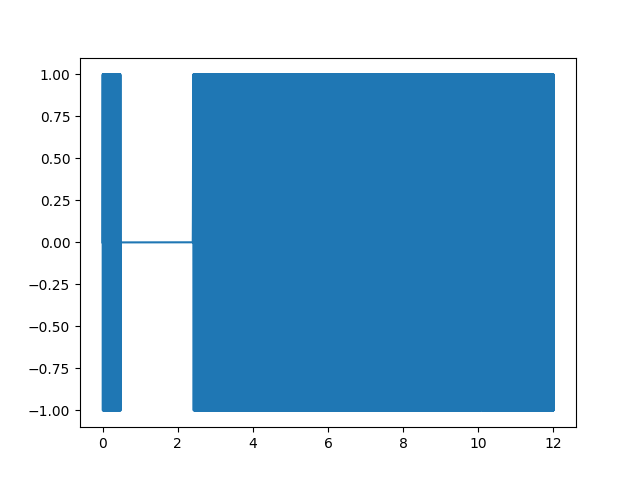

In [29]:
# adding the Synchronization:
u_dict_synch = {}
for u in u_dict:
    u_sync = np.concatenate([u_rec[:n_sync], np.zeros(n_delay)])
    u_dict_synch[u] = np.concatenate([u_sync, u_dict[u]]) 

t_wsync = np.linspace(0, int(len(u_dict_synch["lin"])/fs), len(u_dict_synch["lin"]) , endpoint=False)

plt.figure()
plt.plot(t_wsync, u_dict_synch["lin"])

In [ ]:
# To play the Signals
sd.play(u_dict_synch["lin"], samplerate=fs)
sd.wait()

In [ ]:
##### TEST
# y_lin, f_lin = librosa.load(r"signals\outputs\Barrido lineal.wav", sr = fs) 
# y_rec, f_rec = librosa.load(r"signals\outputs\Señal-rectangular.wav", sr = fs) 
# y_rec = y_rec[int(5*fs):int(5.5*fs)]
# y_lin=y_lin[:int(fs*duration)]

# y_synch_test = np.concatenate([y_rec, np.zeros(int(2*fs)), y_lin])

In [ ]:
# TEST
# plt.figure()
# # plt.plot(t,x_full)
# dur_synch = duration+0.5+2
# t_synch = np.linspace(0,duration+0.5+2, int(fs*dur_synch), endpoint=False)
# plt.plot(u_synch_test)
# plt.plot(y_synch_test)
# plt.grid(True)
# # plt.xlim(0, duration)

## 2. Best signal for estimation
For a accurate analysis, we apply windowing to all non peridoic signals, excpet the white noise. As discussed in the lecture, windowing has no significant effect on white noise due to its properties. 

In our opinion the white noise will lead to the best model of the impulse response $h(n)$ of the speaker-room-microphone system. According to our main objective, the system should be excited in all the frequencys of our interest. Only the exponential $u_{exp}$ and the white noise signal $u_{wn}$ can achieve this, because they provide a broad frequency spectrum. However the other signals have not enough power in the high frquencys ranges, therefore making them less effective for a complete system identification.
Furthermore does the $u_{wn}$ excite all frequencys with the same power. 
Generally white noise has zero autocorrelation at non-zero lags. That will help to to isolate the systems response, because any correlation observed in the output signal can be attributed directly to the system itself.
At last but not least white noise does not introduce harmonic artifact, because it is random and non-periodic.


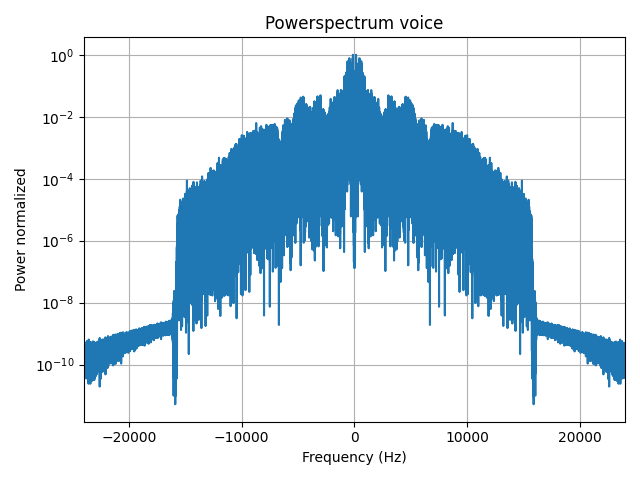

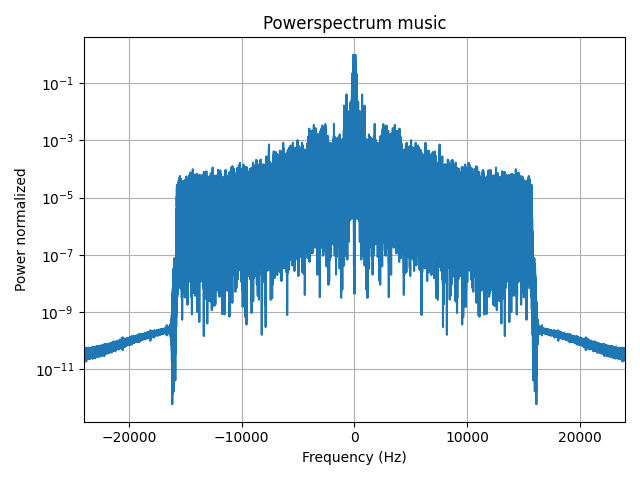

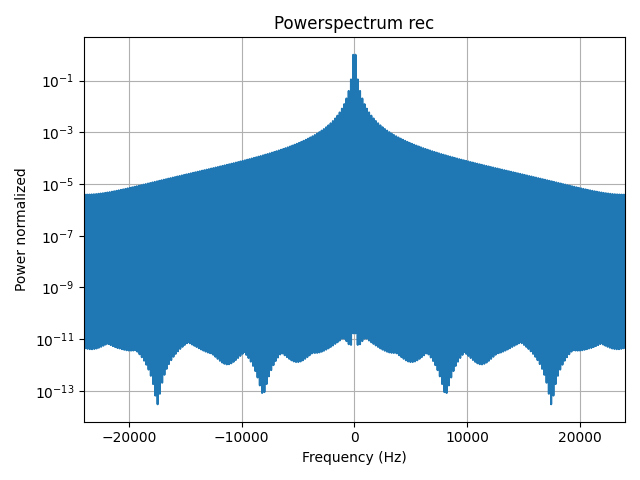

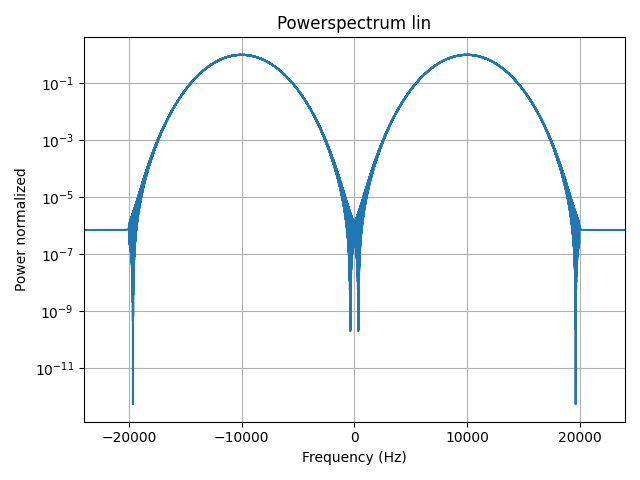

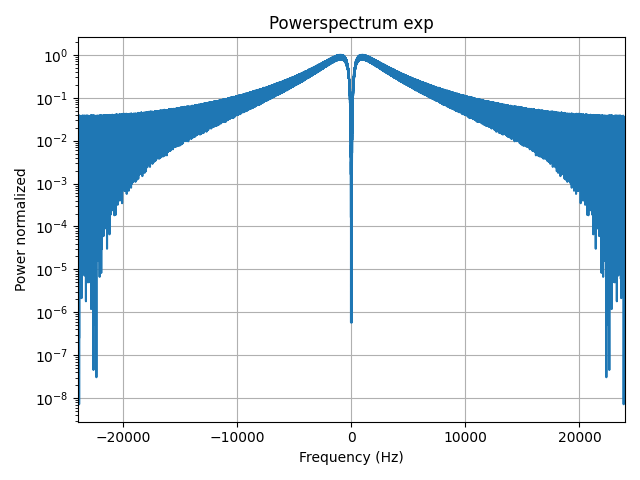

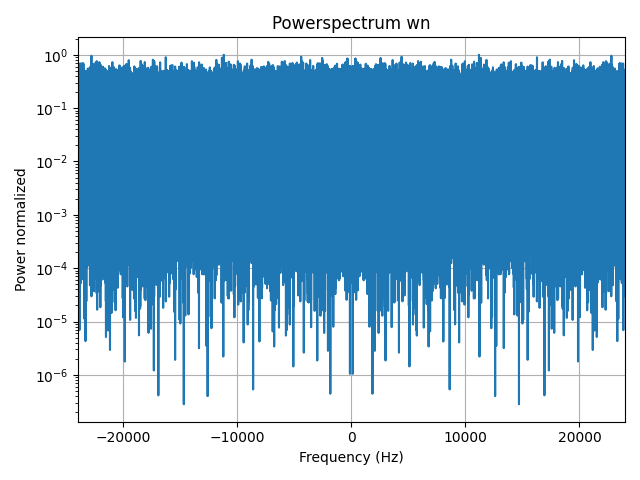

In [30]:
# calculate powerspectrum of the different input signals
f = np.fft.fftshift(np.fft.fftfreq(len(t), d=1/fs)) 
windowing = 1
for key, u in u_dict.items():
    if (key != "u_rec" or key != "u_wn") and windowing == 1:
        window = sp.windows.chebwin(len(u), 100) # windowing to reduce the spectral leakage
        u_win = u * window
    else:
        u_win = u
    U = np.fft.fft(u_win)
    R_u = (U * np.conj(U)) / len(u) # skaling to singal length
    R_u = np.fft.fftshift(np.abs(R_u))
    R_u /= np.max(R_u) # normalizing for better comparision
    plt.figure()
    plt.semilogy(f, R_u)
    plt.title(f"Powerspectrum {key}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power normalized")
    plt.grid(True)
    plt.xlim(-1/2*fs, 1/2*fs)
    plt.tight_layout()

# psds for voice makes no sense.... Voice has max frequency of 80000 Hz 


In [36]:
import scipy.signal
# Synchronization:
# take the first second and calculate the crosscorrelation to recieve the lag between the 2 signals
# take the lag in account for the real excitations
# we have to consider two lists of input signals (1. without synch, 2. with synch)
# implement for loop for 4
def sync(u, y, n_synch, n_delay):
    # can lead to issues if lag is negative, just let the recording run long enough
    # u = u_synch_test
    u_synch = u[:n_synch]
    # y = y_synch_test 
    y_synch = y[:n_synch] 
    # plt.figure()
    # plt.plot(y_synch)
    # plt.plot(u_synch)

    corr = scipy.signal.correlate(u_synch, y_synch, mode='full')  # oder (x, y), je nachdem wie du die Verschiebung interpretierst
    lags = scipy.signal.correlation_lags(len(u_synch), len(y_synch), mode='full')
    lag = lags[np.argmax(corr)]# lag positive -> y has lag to x -> y move to left for lag
    u_real = u[int(n_synch+n_delay):int(n_synch+n_delay+duration*fs)]
    y_real = y[int(n_synch+n_delay-lag):int(n_synch+n_delay+duration*fs-lag)]
    return u_real, y_real

In [39]:
import os
# load all the excitations & outputs in a dict with the keys = i (example: "i": (u_i, y_i))
# naming conventions: u_i and y_i in two different dicts y_i = {voice, music, rec, lin, exp, wn}

y_dict = {}
u_dict = u_dict
sig_dict = {}
folder_path = r"signals\outputs"
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    y, f_y = librosa.load(file_path, sr = fs) 
    key = os.path.splitext(filename)[0]
    y_dict[key] = y

# Create a combined dictionary: i_dict = { "i": (u_i, y_i) }
for key in u_dict_synch:
    if key in y_dict:
        sig_dict[key] = (u_dict_synch[key], y_dict[key])

In [40]:
# correct the lag for all the signals 
for key, (u_i, y_i) in sig_dict.items():
    sig_dict[key] = sync(u_i, y_i, n_sync, n_delay)

ValueError: x and y must have same first dimension, but have shapes (480000,) and (398806,)

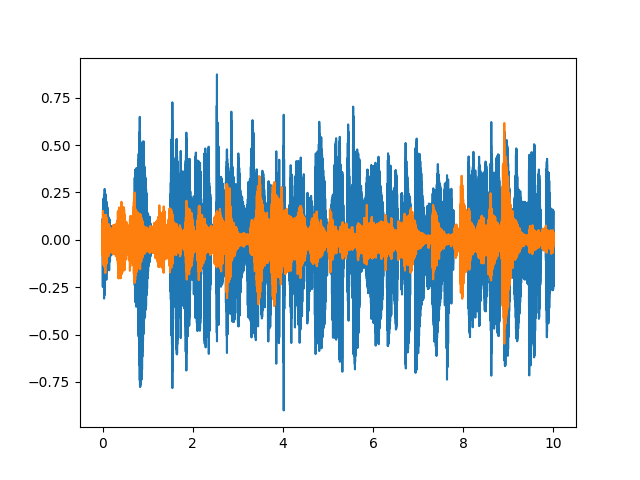

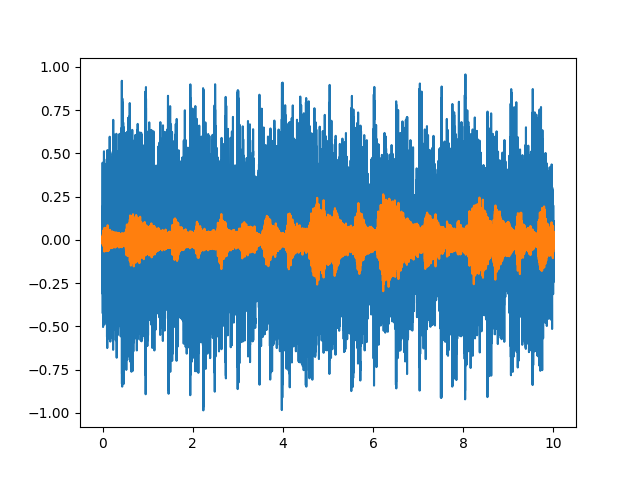

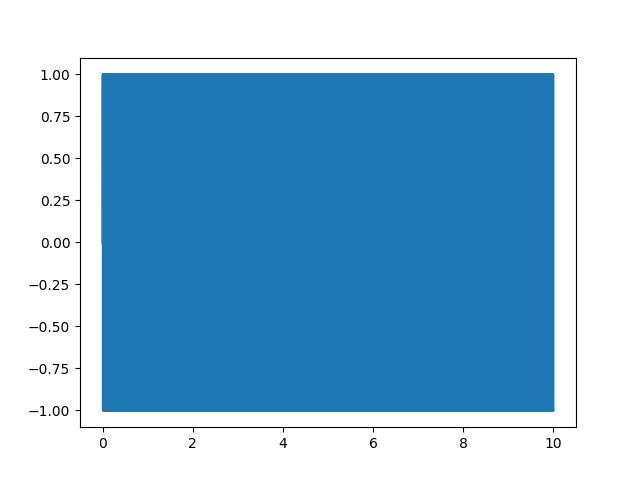

In [ ]:
# plot of the signals:
for key, (u_i, y_i) in sig_dict.items():
    plt.figure()
    plt.plot(t, u_i)
    plt.plot(t, y_i) # state of art error here, because of sync part, we need new signals

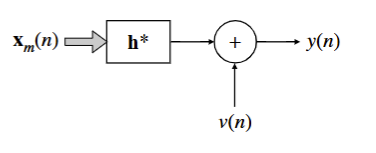

## 3. optimal filterorder $M$

In the following we calculate the optimal filterorder $M$, by determine the value of the optimal root mean square error (MSE) $J_o$ for different $M$:

$J_0 = \sigma_y^2 - \mathbf{p}^H \mathbf{R}^{-1} \mathbf{p} = \sigma_y^2 - \mathbf{p}^H \mathbf{w}_o$

We decided to calculate $\mathbf{w}_o$ by solving the normal equation system $\mathbf{R} \mathbf{w}_o = \mathbf{p}$ instead of calculating the inverse $\mathbf{R}^{-1}$. Calculataing the inverse is usually more expensive and numarically unstable. But it is possible to calculate \mathbf{w}_o$ even more efficient  with the Levinson-Durbin Algorithm, that would lead to a computational complexity to $\mathcal{O}(n^2)$ instead of $\mathcal{O}(n^3)$. If we focus even more on the autocorrelation Matrix of the input $R_xx$ we can come to the conclussion, that is very large sparse matrix. We will see...

In [ ]:
# plt.figure()
# # plt.plot(t,x_full)
# plt.plot(t,y_lin)
# plt.grid(True)
# plt.xlim(0, duration)

In [ ]:
### TEST signal
fs = 48000       # Sampling rate
duration = 10    # seconds
N = fs * duration

# Example white noise input signal x[n]
np.random.seed(0)
x_test = np.random.randn(N)

# Simulate a simple room impulse response h[n] as a small FIR filter with a few echoes
h = np.zeros(500)         # 500-sample impulse response (~10 ms)
h[0] = 1.0                # direct sound
h[50] = 0.5               # first reflection
h[120] = 0.3              # second reflection
h[300] = 0.2              # late reflection

# Generate output y[n] by convolving x[n] with room h[n]
y_test = np.convolve(x_test, h)[:N]  # truncate to original length

# print(f"x shape: {x.shape}, y shape: {y.shape}")
# print("First 10 samples of x:", x[:10])
# print("First 10 samples of y:", y[:10])
# plt.figure()
# plt.plot(x)
# plt.figure()
# plt.plot(y)

In [42]:
def is_hermitian(R, tol=1e-10):
    return np.allclose(R, R.conj().T, atol=tol)

def is_positive_definite(R):
    eigvals = np.linalg.eigvalsh(R)  # eigvalsh for Hermitian matrices (faster and more stable)
    return np.all(eigvals > 0)

def is_positive_semidefinite(R, tol=1e-12):
    eigvals = np.linalg.eigvalsh(R)
    return np.all(eigvals >= -tol)  # small negative tol accounts for numerical errors


def check_R(R):
    if not is_hermitian(R):
        print("Matrix R is NOT Hermitian!")
    else:
        print("Matrix R is Hermitian.")

    if is_positive_definite(R):
        print("Matrix R is positive definite.")
    elif is_positive_semidefinite(R):
        print("Matrix R is positive semi-definite.")
    else:
        print("Matrix R is NOT positive (semi-)definite.")


In [ ]:
import scipy.linalg as la
import pandas as pd

cut_off = 2*fs
x = u_dict["lin"]
y = y_dict["lin"]
x = x[int(cut_off):int(x.size-cut_off)]
y = y[int(cut_off):int(x.size+cut_off)] # input from german
# x = x_test
# y = y_test
sigma_y2 = np.mean(np.abs(y)**2)  # E{|y|^2}

X = np.fft.fft(x)  # FFT of signal windowing for spectral leakage
Y = np.fft.fft(y)
N = len(x)
rxx = np.fft.ifft(X * np.conj(X)) / N # autocorrelation SEQUENCE
pxy = np.fft.ifft(Y * np.conj(X)) / N

Jo_tab = []
M_tab = [1, 100, 200, 500, 1000, 5000, 6000]# np.arange(1000, 15001, 1000) # [1, 100, 200, 500, 1000, 5000, 6000, 10000, 15000]

for M in M_tab:
    R = la.toeplitz(rxx[:M])  # autocorrelation matrix 
    p = np.conj(pxy)[:M]  # cross correlation vector
    check_R(R)
    Jo = sigma_y2 - np.conj(p) @ la.solve(R, p)  # sigma_y^2 - p^H R^-1 p
    Jo_tab.append(np.real(Jo))  # imaginary parts are e-14 and are just floating point error basically

# df = pd.DataFrame(R)
# df
   

In [ ]:
plt.figure()
plt.plot(M_tab, Jo_tab)
plt.xlabel("M")
plt.ylabel("Jo")
print(np.array(Jo_tab))

## 4. Estimation of $h(n)$ and more

compare between the different signals we recorded --> conclusions about which
ones excite the frequency spectrum more hence allow us to build a better filter
for the room

In [ ]:
M = 500  # optimal M from previous question
for key, (u, y) in sig_dict:
    if key == "lin":
        continue
    print(key)
    x = x[int(cut_off):int(x.size-cut_off)]
    y = y[int(cut_off):int(x.size+cut_off)]

    sigma_y2 = np.mean(np.abs(y)**2)  # E{|y|^2}

    X = np.fft.fft(x)  # FFT of signal windowing for spectral leakage
    Y = np.fft.fft(y)
    N = len(x)

    rxx = np.fft.ifft(X * np.conj(X)) / N # autocorrelation SEQUENCE
    pxy = np.fft.ifft(Y * np.conj(X)) / N

    R = la.toeplitz(rxx[:M])  # autocorrelation matrix 
    p = np.conj(pxy)[:M]  # cross correlation vector

    # characteristic equation: Rw_o = p
    w_o = la.solve(R, p)
    print(w_o)  # this is the h(n) 
    '''
    H_hat tells us how the room modifies each frequency, so basically which 
    frequencies are amplified, attenuated, or delayed etc 
    '''
    H_hat = np.fft.fft(w_o)  # the frequency response
    plt.figure()
    plt.plot("$\hat{H}(e^{j\omega}$")

    '''
    E = 1 - sigma_yhato^2 / sigma_y^2
    sigma_y^2 = E{|y|^2} --> we're estimating this with just a mean
    sigma_yhato^2 = E{|y_hato|^2} = p^H w_o
    '''
    sigma_y_hato2 = np.conj(p) @ w_o
    MSE_normalizado = 1 - sigma_y_hato2 / sigma_y2
    print(MSE_normalizado)


## 5. Comparision 

just discuss which had lowest normalised MSE vs. what we expected

In [ ]:
'''
q6. best h(n) would be one with lowest MSE most likely --> the music recorded
in the room can be described as y(n) = x(n) * h(n) where x(n) is the og music
and its convoluted by the room so we want an inverse filter
since convolution in the time domain is multiplication in the frequency domain
so Y(f) = X(f) H(f) --> X(f) = Y(f) / H(f)
'''
Y = np.fft.fft(y)  # putting signal into frequency domain
X_hat = Y / H_hat  # "unconvoluting" the signal in the frequency domain
x_hat = np.fft.ifft(X_hat)  # bringing it back to the time domain


In [ ]:
sd.play(x_hat, samplerate=fs)
sd.wait()